In [1]:
# General libraries:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Personal libraries:
from robin_helperfunctions import round_to_hour
from robinhoodstrategy import cryptoStrategy, BackcastStrategy, Trade

# Deep learning libraries:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')

# Pull just the value fields:
df = df[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']]

# Load just ~2018 onwards:
# df = df[2500:]

df.head()

,price_close,price_open,price_high,price_low,volume_traded,trades_count
0,11.8895,11.87000,11.90000,11.85972,1076.171006,48
1,12.0000,11.89000,12.00000,11.89000,6184.443260,182
2,12.0300,12.00000,12.03000,11.93356,3391.487460,120
3,12.2000,12.02591,12.20000,12.00000,1590.240506,53
4,12.4310,12.20000,12.54799,12.20000,4801.330298,164


In [3]:
def entry_flag(df, lookforward_num=6):
    
    '''If there will be over a 5% gain in the next 6 periods, flag as a 1. Else 0.'''
    
    df['pctchange'] = df[['price_close']].pct_change(lookforward_num)
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['pctchange'] >= 0.05:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [4]:
df['entry_flag'] = entry_flag(df)
df['entry_flag'].value_counts()

0.0    7201
1.0    1206
Name: entry_flag, dtype: int64

In [10]:
def create_sequence(df, n_input): 
    
    X,y = list(), list()
    
    start = n_input
    for _ in range(len(df)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(df) - n_input:
            df_slice = df.iloc[start:end]
            X.append(np.array(df_slice[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']]))
            y.append(df_slice['entry_flag'].tolist()[-1])
        # move along one time step
        start += 1
    return np.array(X), np.array(y).reshape(-1,1)

seq_len = 12
X1, y1 = create_sequence(df, seq_len)
print(type(y1))
print(X1.shape, y1.shape)

<class 'numpy.ndarray'>
(8378, 12, 6) (8378, 1)


In [9]:
def create_sequence(df, n_input): 
    
    data = np.array(df)
    
    X = list()
    start = n_input
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input*2].values).reshape(-1,1)

seq_len = 12
df_features = df.drop(columns=['pctchange', 'entry_flag'])
X2 = create_sequence(df_features, seq_len)
y2 = create_targets(df, seq_len)
print(type(y2))
print(X2.shape, y2.shape)

<class 'numpy.ndarray'>
(8378, 12, 6) (8378, 1)


In [ ]:
df.head(30)

In [29]:
type(X1[1][0][0])

numpy.float64

In [13]:
def normalized_df(X):
    return np.array([x/x[0]-1 for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [40]:
normalized_df(X1)[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.75249169e-03, -4.28952923e-02, -3.75335807e-02,
        -5.02008368e-03, -7.18053690e-01, -7.48502994e-01],
       [-2.66611296e-04, -4.76573494e-02, -3.65549444e-02,
        -3.25188285e-03, -8.28855513e-01, -8.71257485e-01],
       [ 1.60714286e-02, -3.65549444e-02, -2.18833952e-02,
         8.36820084e-03, -9.46555088e-01, -9.25149701e-01],
       [ 2.49169435e-03, -3.57554049e-02, -3.42522707e-02,
         5.31297071e-03, -9.48614046e-01, -9.55089820e-01],
       [ 1.50581395e-02, -3.49558654e-02, -1.67991237e-02,
         5.02677824e-03, -7.95770724e-01, -8.11377246e-01],
       [ 2.49169435e-03, -2.25797940e-02, -2.25797940e-02,
         1.00418410e-02, -9.03603230e-01, -8.83233533e-01],
       [ 3.28073090e-03, -3.49558654e-02, -2.13692913e-02,
         7.53891213e-03, -7.57294653e-01, -7.81437126e-01],
       [ 6.43687708e-04, -3.41963029e-02, -2.852

In [41]:
normalized_df(X2)[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.75249169e-03, -4.28952923e-02, -3.75335807e-02,
        -5.02008368e-03, -7.18053690e-01, -7.48502994e-01],
       [-2.66611296e-04, -4.76573494e-02, -3.65549444e-02,
        -3.25188285e-03, -8.28855513e-01, -8.71257485e-01],
       [ 1.60714286e-02, -3.65549444e-02, -2.18833952e-02,
         8.36820084e-03, -9.46555088e-01, -9.25149701e-01],
       [ 2.49169435e-03, -3.57554049e-02, -3.42522707e-02,
         5.31297071e-03, -9.48614046e-01, -9.55089820e-01],
       [ 1.50581395e-02, -3.49558654e-02, -1.67991237e-02,
         5.02677824e-03, -7.95770724e-01, -8.11377246e-01],
       [ 2.49169435e-03, -2.25797940e-02, -2.25797940e-02,
         1.00418410e-02, -9.03603230e-01, -8.83233533e-01],
       [ 3.28073090e-03, -3.49558654e-02, -2.13692913e-02,
         7.53891213e-03, -7.57294653e-01, -7.81437126e-01],
       [ 6.43687708e-04, -3.41963029e-02, -2.852

In [73]:
pd.DataFrame(X1.reshape(8378,72))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,12.04000,12.50720,12.50720,11.95000,10626.586878,334.0,12.01890,11.97070,12.03776,11.89001,...,12.13720,12.07000,352.656597,12.0,12.10000,12.07000,12.13519,12.05787,305.215230,17.0
1,12.01890,11.97070,12.03776,11.89001,2996.126954,84.0,12.03679,11.91114,12.05000,11.91114,...,12.13519,12.05787,305.215230,17.0,12.10400,12.07812,12.11987,12.07000,1653.463689,30.0
2,12.03679,11.91114,12.05000,11.91114,1818.681760,43.0,12.23350,12.05000,12.23350,12.05000,...,12.11987,12.07000,1653.463689,30.0,12.08990,12.10290,12.10649,12.05000,661.240808,19.0
3,12.23350,12.05000,12.23350,12.05000,567.937001,25.0,12.07000,12.06000,12.07880,12.01349,...,12.10649,12.05000,661.240808,19.0,12.16000,12.05018,12.17810,12.05018,843.588351,32.0
4,12.07000,12.06000,12.07880,12.01349,546.057300,15.0,12.22130,12.07000,12.29709,12.01007,...,12.17810,12.05018,843.588351,32.0,12.06441,12.16359,12.16359,12.02000,991.638430,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,443.47000,440.47000,450.00000,438.15000,18291.390638,3655.0,437.42000,443.40000,446.10000,424.25000,...,393.50000,376.59000,17813.063640,3789.0,385.82000,391.92000,393.25000,384.79000,9719.320172,1893.0
8374,437.42000,443.40000,446.10000,424.25000,20770.364411,4036.0,423.23000,437.42000,439.27000,421.54000,...,393.25000,384.79000,9719.320172,1893.0,387.83000,385.61000,394.80000,384.96000,7423.211126,2438.0
8375,423.23000,437.42000,439.27000,421.54000,11957.890791,2702.0,403.65000,423.19000,425.93000,391.00000,...,394.80000,384.96000,7423.211126,2438.0,381.20000,387.48000,389.33000,378.00000,33717.613690,3301.0
8376,403.65000,423.19000,425.93000,391.00000,89937.587105,11655.0,402.41000,403.62000,408.00000,392.14000,...,389.33000,378.00000,33717.613690,3301.0,356.41000,380.70000,380.70000,347.88000,46714.464981,6678.0


In [50]:
y1[8362]

array([0.])

In [51]:
y2[8362]

array([1.])

In [19]:
X_norm = normalized_df(X2)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6702, 12, 6) (6702, 1)
(1676, 12, 6) (1676, 1)


In [20]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [21]:
# define the CNN model
model = Sequential()
model.add(Conv1D(64, 6, activation='relu', input_shape=(n_timesteps,n_features))) 
model.add(Conv1D(64, 6, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

0.9677804112434387


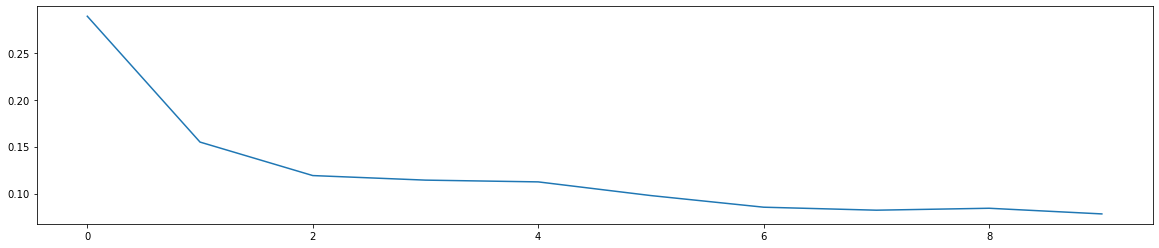

In [22]:
verbose, epochs, batch_size = 0, 10, 32
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
plt.figure(figsize=(20,4))
print(accuracy)
plt.plot(results.history['loss'])
plt.show()

In [23]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1532
1     144
dtype: int64

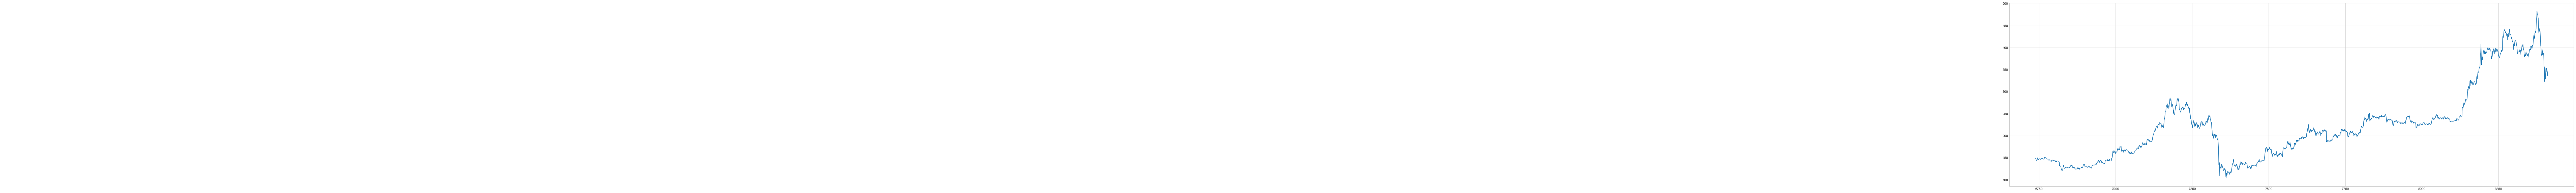

In [24]:
df_plot = df[-len(X_test):]
df_plot['predictions'] = predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,10))

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 8] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points')
plt.show()

In [116]:
print(classification_report(df_plot['entry_flag'][10:-10].values, df_plot['predictions'][10:-10].values))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88      1464
         1.0       0.17      0.22      0.19       192

    accuracy                           0.78      1656
   macro avg       0.53      0.54      0.53      1656
weighted avg       0.81      0.78      0.80      1656



In [102]:
confusion_matrix(df_plot['entry_flag'][10:-10].values, df_plot['predictions'][10:-10].values)

array([[1465,    1],
       [ 192,    0]])

model.save('4hr_6period_cnn.h5')

___

In [103]:
current_data = np.array(df.tail(12)[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']])

In [104]:
round(model.predict(current_data.reshape(1,12,6))[0][0])

0.0

In [76]:
df_test = pd.DataFrame({'x':np.arange(100), 'y':np.arange(100)})

In [77]:
df_test

,x,y
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
95,95,95
96,96,96
97,97,97
98,98,98


In [ ]:
n_input = 4

X,y = list(), list()

start = n_input
for _ in range(len(df_test)):
    # define the end of the input sequence
    end = start + n_input
    # ensure we have enough data for this instance 
    if end <= len(df) - n_input:
        df_slice = df.iloc[start:end]
        X.append(np.array(df_slice[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']]))
        y.append(df_slice['entry_flag'].tolist()[-1])
    # move along one time step
    start += 1